#Instalacion Librerias

In [ ]:
!pip3 install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10855094 sha256=5b7bdca39a20dc6074a9c36479dc18e70278c4478ad25786a65e4dbd3385eec6
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


#Importacion de Librerias

In [ ]:
import implicit #separarlo para no tener que descargarlo cada vez

In [ ]:
import os
import zipfile
import time

import random
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from numpy import log2



#Metricas

### AP@K

In [ ]:
def average_precision_at_k(relevance_vector, k):

  def precision_at_k(ranking, k):
    assert 1 <= k <= ranking.size
    return np.asarray(ranking)[:k].mean()


  total_sum = 0
  relevance_vector = np.asarray(relevance_vector)
  n_relevant = sum(relevance_vector)
  if n_relevant == 0:
    return 0

  for i in range(k):
    total_sum += precision_at_k(relevance_vector, i+1) * relevance_vector[i]
  return total_sum / min(k, n_relevant)

### NDCG@K

In [ ]:
def ndcg_at_k(relevance_vector, k):

  if relevance_vector.sum() == 0:
    return 0

  def dcg_at_k(ranking, k):
    total_sum = 0
    ranking = np.asarray(ranking)[:k]
    for i in range(len(ranking)):
      total_sum += ranking[i] / np.log2(i+2) # +2 porque i parte en 1 y se le suma 1
    return total_sum


  dcg = dcg_at_k(relevance_vector, k)
  idcg = dcg_at_k(sorted(relevance_vector, reverse=True), k)
  return dcg / idcg

### Diversity

In [ ]:
def diversity(recomended_items):
  categories = set()
  for item_id in recomended_items:
    #Se ignoran los items que no se encuentren en el set de validacion
    if item_id not in item_genre_dict:
      continue
    for category in item_genre_dict[item_id]:
      categories.add(category)
  return len(categories)

### Novelty

In [ ]:
def novelty_val(recomended_items):
  novelty = 0
  for item_id in recomended_items:
    #Se ignoran los items que no se encuentren en el set de validacion
    if item_id not in item_popularity_dict:
      continue

    novelty += log2(1/ item_popularity_dict[item_id])
  return novelty / len(recomended_items)

# Cargar datos

In [ ]:
!unzip book-crossing.zip -d /content

Archive:  book-crossing.zip
  inflating: /content/Books.csv      
  inflating: /content/Ratings.csv    
  inflating: /content/Users.csv      


In [ ]:
import pandas as pd

books = pd.read_csv('Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
ratings = pd.read_csv('Ratings.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
users = pd.read_csv('Users.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)


#Construccion de DataFrame


In [ ]:
books.columns = ['isbn', 'title', 'author', 'year', 'publisher']
ratings.columns = ['user_id', 'isbn', 'rating']

ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')

In [ ]:
data = pd.merge(ratings, books[['isbn', 'title', 'author']], on='isbn')

In [ ]:
data = data.rename(columns={
    'user_id': 'user_id',
    'isbn': 'item_id',
    'author': 'genre'   #autores como categorias
})


In [ ]:
# Convertir isbns en ids
item_ids = data['item_id'].unique()
item_id_map = {original_id: index for index, original_id in enumerate(item_ids)}
data['item_id'] = data['item_id'].map(item_id_map)

In [ ]:
ratings_df = data #Cambiar a variable ratings_df utilizada en el resto del codigo

## Cargar generos

In [ ]:
item_genre_dict = {}
for index, row in ratings_df.iterrows():
    item_id = row['item_id']
    genres = [row['genre']]
    item_genre_dict[item_id] = genres

##Crear split entrenamiento, validación y test

In [ ]:
uir_df = ratings_df[['user_id', 'item_id', 'rating']]

train_df, test_df = train_test_split(uir_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Training set size: 618711
Validation set size: 206238
Test set size: 206238


# Crear datos de relevacia e interacción


In [ ]:
train_df_relevance = train_df.copy()
val_df_relevance = val_df.copy()
test_df_relevance = test_df.copy()

train_df_relevance['rating'] = [1 if x >= 5 else 0 for x in train_df_relevance['rating']]
val_df_relevance['rating'] = [1 if x >= 5 else 0 for x in val_df_relevance['rating']]
test_df_relevance['rating'] = [1 if x >= 5 else 0 for x in test_df_relevance['rating']]

## Mapeo de indices

In [ ]:
user_ids = train_df['user_id'].unique()
item_ids = train_df['item_id'].unique()

user_id_map = {original_id: index for index, original_id in enumerate(user_ids)}
item_id_map = {original_id: index for index, original_id in enumerate(item_ids)}


train_df['user_index'] = train_df['user_id'].map(user_id_map)
train_df['item_index'] = train_df['item_id'].map(item_id_map)

user_item_matrix = csr_matrix((train_df['rating'], (train_df['user_index'], train_df['item_index'])))


In [ ]:
print(user_item_matrix[:5, :10].toarray())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 5. 0. 0. 0. 0. 0.]]


## Mapeo de users: [items]

In [ ]:
user_item_train = train_df.groupby('user_id')['item_id'].apply(set).to_dict()
user_item_val = val_df.groupby('user_id')['item_id'].apply(set).to_dict()
user_item_test = test_df.groupby('user_id')['item_id'].apply(set).to_dict()

## Obtener popularidad de los items

In [ ]:
item_popularity = ratings_df['item_id'].value_counts()
total_ratings = len(ratings_df)
item_popularity_dict = (item_popularity / total_ratings).to_dict()

#Creacion de Contexto

In [ ]:
ctx = {
  "user_id_map": user_id_map,
  "user_item_matrix": user_item_matrix,
  "user_item_val": user_item_val,
  "user_item_test": user_item_test,
  "index_to_item_id": {idx: iid for iid, idx in item_id_map.items()}
}

# Funciones de recomendación

In [ ]:
def get_rel_vector(model, n, user_id, library_or_type, ctx, val=False):

    """
    Devuelve:
      - rel_vector: array bool de largo n indicando si cada ítem recomendado es relevante.
      - rec_items: lista de item_id recomendados (IDs originales).

    Usa:
      - Si library_or_type == 'implicit': model.recommend(...) con la fila del usuario.
      - Si 'random'/'popular': model.reccomend(tipo, n).
      - Ground truth: ctx["user_item_val"] si val=True, sino ctx["user_item_test"].

    Notas:
      - Si el usuario no tiene ground truth o no está en user_id_map (cold-start), retorna
        un vector de ceros y lista vacía.
      - ctx debe incluir: user_id_map, user_item_matrix, user_item_val, user_item_test,
        index_to_item_id.
    """

    m = ctx
    relevant_items = (m["user_item_val"] if val else m["user_item_test"]).get(user_id, set())

    empty_rel = np.zeros(n, dtype=bool)
    empty_list = []

    if not relevant_items:
        return empty_rel, empty_list

    if library_or_type == 'implicit':

        if user_id not in m["user_id_map"]:
            return empty_rel, empty_list
        urow = m["user_id_map"][user_id]
        rec_indices, _ = model.recommend(urow, m["user_item_matrix"][urow], N=n)
        rec_items = [m["index_to_item_id"][i] for i in rec_indices]

    elif library_or_type == "tensorflow":
        if user_id not in m["user_id_map"]:
            return empty_rel, empty_list
        rec_items = deepfm_recommend_top_k(model, train_df, user_id, n)


    else: # "random" / "popular"
        rec_items = model.reccomend(library_or_type, n)

    rel_vector = np.isin(rec_items, list(relevant_items))
    return (rel_vector, rec_items)

## Metricas base promedio

In [ ]:
no_sample = -1
def get_base_metrics(model, n, library_or_type, ctx, val = False, user_sample_size = no_sample):

  """
    Calcula promedios sobre usuarios de:
      - AP@N, nDCG@N
      - Diversidad (géneros únicos en el Top-N)
      - Novedad (menos popular = más novedoso)

    Flujo:
      - Toma usuarios de validación (val=True) o test (val=False).
      - Para cada usuario: obtiene (rel_vector, rec_items) con get_rel_vector(...),
        acumula AP@N, nDCG@N, diversidad y novedad.
      - Devuelve los cuatro promedios.

    Retorna:
      (mean_ap, mean_ndcg, mean_div, mean_nov)
  """
  m = ctx

  mean_ap = 0
  mean_ndcg = 0
  mean_div = 0
  mean_nov = 0
  users_to_evaluate = (m["user_item_val"].keys() if val else m["user_item_test"].keys())

  if user_sample_size != no_sample:
    users_to_evaluate = random.sample(list(users_to_evaluate), user_sample_size)

  num = len(users_to_evaluate)



  for user_id in users_to_evaluate:
    rel_vec, rec_items = get_rel_vector(model, n, user_id, library_or_type, m, val)
    if len(rel_vec) == 0 or len(rec_items) == 0:
      continue
    mean_ap   += average_precision_at_k(rel_vec, n)
    mean_ndcg += ndcg_at_k(rel_vec, n)
    mean_div  += diversity(rec_items)
    mean_nov  += novelty_val(rec_items)

  return mean_ap/num, mean_ndcg/num, mean_div/num, mean_nov/num

# Recomendador base

In [ ]:
class RecomendadorBase:
  def __init__(self):
    pass

  def reccomend(self, reccomender_type, n):
    if reccomender_type == "random":
        rec = random.sample(list(item_id_map.keys()), n)
    elif reccomender_type == "popular":
        rec = list(item_popularity.index[:n])
    return rec

# Baseline popular

In [ ]:

mean_ap, mean_ndcg, mean_diversity, mean_novelty = get_base_metrics(RecomendadorBase(), 10, "popular", ctx)
print("Mean AP:", mean_ap)
print("Mean NDCG:", mean_ndcg)
print("Mean Diversity:", mean_diversity)
print("Mean Novelty:", mean_novelty)

Mean AP: 0.02117613137121559
Mean NDCG: 0.026645016713392738
Mean Diversity: 9.0
Mean Novelty: 10.308011272824363


Guardar valores

In [ ]:
most_popular_mean_ap =   0.02117613137121559
most_popular_mean_ndcg = 0.02664501671339273
most_popular_mean_diversity = 9.0
most_popular_mean_novelty = 10.308011272824363

# Baseline random

In [ ]:
mean_ap_random = 0
mean_ndcg_random = 0
mean_diversity_random = 0
mean_novelty_random = 0


mean_ap_i, mean_ndcg_i, mean_diversity_i, mean_novelty_i = get_base_metrics(RecomendadorBase(), 10, "random",ctx)
mean_ap_random += mean_ap_i
mean_ndcg_random += mean_ndcg_i
mean_diversity_random += mean_diversity_i
mean_novelty_random += mean_novelty_i

mean_ap_random = mean_ap_random
mean_ndcg_random = mean_ndcg_random
mean_diversity_random = mean_diversity_random
mean_novelty_random = mean_novelty_random

print("Mean AP:", mean_ap_random)
print("Mean NDCG:", mean_ndcg_random)
print("Mean Diversity:", mean_diversity_random)
print("Mean Novelty:", mean_novelty_random)

Mean AP: 0.00014414152169527793
Mean NDCG: 0.00020505295377352647
Mean Diversity: 9.994798648721112
Mean Novelty: 18.808362493466937


Guardar valores.

In [ ]:
mean_ap_random = 0.00014414152169527793
mean_ndcg_random = 0.00020505295377352647
mean_diversity = 9.994798648721112
mean_novelty = 18.808362493466937

# Métrica CO2E

In [ ]:
# datos obtenidos de google cloud
carbon_intensity_dict ={'africa-south1': 657,
 'asia-east1': 439,
 'asia-east2': 505,
 'asia-northeast1': 453,
 'asia-northeast2': 296,
 'asia-northeast3': 357,
 'asia-south1': 679,
 'asia-south2': 532,
 'asia-southeast1': 367,
 'asia-southeast2': 561,
 'australia-southeast1': 498,
 'australia-southeast2': 454,
 'europe-central2': 643,
 'europe-north1': 39,
 'europe-north2': 3,
 'europe-southwest1': 89,
 'europe-west1': 103,
 'europe-west2': 106,
 'europe-west3': 276,
 'europe-west4': 209,
 'europe-west6': 15,
 'europe-west8': 202,
 'europe-west9': 16,
 'europe-west10': 276,
 'europe-west12': 202,
 'me-central2': 382,
 'me-west1': 434,
 'northamerica-northeast1': 5,
 'northamerica-northeast2': 59,
 'northamerica-south1': 305,
 'southamerica-east1': 67,
 'southamerica-west1': 238,
 'us-central1': 413,
 'us-east1': 576,
 'us-east2': 340,
 'us-east4': 323,
 'us-south1': 303,
 'us-west1': 79,
 'us-west2': 169,
 'us-west3': 555,}
mean_carbon_intensity = sum(carbon_intensity_dict.values()) / len(carbon_intensity_dict)
print(mean_carbon_intensity)

305.625


In [ ]:
energy_consumption_t4 = 70 #Watts
mean_ap_random =3.7949697723844025e-05
mean_ndcg_random =6.10947657503998e-05
mean_carbon_intensity=305.625
#ls_default_time está en segundos, y energy_consumption_t4 en W. Por eso debes dividir por 1000 y por 3600 (no solo por 1000).

def get_co2e(time_seconds, power_watts, carbon_intensity_g_per_kwh):
    # energía en kWh = W*s / (1000*3600)
    energy_kwh = power_watts * time_seconds / (1000.0 * 3600.0)
    return carbon_intensity_g_per_kwh * energy_kwh  # gCO2

def get_co2e_metrics(map_val, ndcg_val, time_seconds, power_watts, carbon_intensity_g_per_kwh,
                     map_random_baseline, ndcg_random_baseline):
    co2e = get_co2e(time_seconds, power_watts, carbon_intensity_g_per_kwh)
    map_c  = (map_val  - map_random_baseline)  / co2e * 100.0
    ndcg_c = (ndcg_val - ndcg_random_baseline) / co2e * 100.0
    return map_c, ndcg_c, co2e

# Métrica Base con modelo ALS con hiperparámetos por defecto

Hipeparametros por defecto: factors = 100, regularization = 0.01 (https://benfred.github.io/implicit/api/models/cpu/als.html)

*Usar T4*

In [ ]:

default_als = implicit.als.AlternatingLeastSquares(use_gpu=True)
training_start = time.time()
default_als.fit(user_item_matrix)
training_end = time.time()
als_default_time = training_end - training_start

print("Training time:", als_default_time)

  0%|          | 0/15 [00:00<?, ?it/s]

Training time: 1.4438591003417969


In [ ]:
# Evaluación del modelo ALS por defecto
mean_ap, mean_ndcg, mean_diversity, mean_novelty = get_base_metrics(
    model=default_als,
    n=10,
    library_or_type="implicit",
    ctx=ctx,
    val=False  # usa test; pon True si quieres validación
)
# Cálculo de eficiencia/CO2E
map_c, ndcg_c, co2e = get_co2e_metrics(
    map_val=mean_ap,
    ndcg_val=mean_ndcg,
    time_seconds=als_default_time,
    power_watts=energy_consumption_t4,
    carbon_intensity_g_per_kwh=mean_carbon_intensity,
    map_random_baseline=mean_ap_random,
    ndcg_random_baseline=mean_ndcg_random
)

print("Mean AP:", mean_ap)
print("Mean NDCG:", mean_ndcg)
print("Mean Diversity:", mean_diversity)
print("Mean Novelty:", mean_novelty)
print("CO2E (gCO2):", co2e)
print("MAP-C (%):", map_c)
print("NDCG-C (%):", ndcg_c)

Mean AP: 0.017316926365400824
Mean NDCG: 0.02358971354305868
Mean Diversity: 5.917073301517507
Mean Novelty: 8.108062838782097
CO2E (gCO2): 0.008580433507760365
MAP-C (%): 201.3764998242738
NDCG-C (%): 274.2124713865377


# Modelo BPR con hiperparámetos por defecto

In [ ]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking(
    factors=400,          # latentes
    iterations=40,        # epochs
    learning_rate=0.05,   # (default suele ir bien)
    regularization=0.01,  # opcional
    random_state=42,      # reproducibilidad
    use_gpu=True
)

bpr_start = time.time()
model_bpr.fit(user_item_matrix)
bpr_end = time.time()
bpr_time = bpr_end - bpr_start
print("BPR training time (s):", bpr_time)

# 2) Evaluacion
mean_ap_bpr, mean_ndcg_bpr, mean_div_bpr, mean_nov_bpr = get_base_metrics(
    model=model_bpr,
    n=10,
    library_or_type="implicit",
    ctx=ctx,
    val=False      # usa test; pon True para validación
)

# 3) Métrica de CO2 y eficiencias -C
map_c_bpr, ndcg_c_bpr, co2e_bpr = get_co2e_metrics(
    map_val=mean_ap_bpr,
    ndcg_val=mean_ndcg_bpr,
    time_seconds=bpr_time,
    power_watts=energy_consumption_t4,
    carbon_intensity_g_per_kwh=mean_carbon_intensity,
    map_random_baseline=mean_ap_random,
    ndcg_random_baseline=mean_ndcg_random
)

print("BPR — AP@10:", mean_ap_bpr)
print("BPR — nDCG@10:", mean_ndcg_bpr)
print("BPR — Diversity:", mean_div_bpr)
print("BPR — Novelty:", mean_nov_bpr)
print("BPR — CO2E (g):", co2e_bpr)
print("BPR — MAP-C (%):", map_c_bpr)
print("BPR — NDCG-C (%):", ndcg_c_bpr)

  0%|          | 0/40 [00:00<?, ?it/s]

BPR training time (s): 2.801515817642212
BPR — AP@10: 0.010146544057712212
BPR — nDCG@10: 0.013867865902786523
BPR — Diversity: 6.48088369349563
BPR — Novelty: 10.64242163439017
BPR — CO2E (g): 0.01664859139546752
BPR — MAP-C (%): 60.717415184688676
BPR — NDCG-C (%): 82.93056637088789


# Filtros de resultados

Filtrar para obtener el menor valor co2 para las métricas ndcg y map. Es decir, si para un valor de ndcg se obtiene un valor co2#1 y otro modelo tiene un valor mayor de ndcg con co2#2 < co2#1, se elimina el primer modelo.

In [ ]:
def filter_for_efficiency_in_each_metric(results_list):

    sorted_by_ndcg_c = sorted(results_list, key=lambda x: x['ndcg_c'], reverse=True)
    sorted_by_map_c = sorted(results_list, key=lambda x: x['map_c'], reverse=True)

    best_ndcg_c = sorted_by_ndcg_c[0]
    best_map_c = sorted_by_map_c[0]

    return {
        'best_ndcg_c': best_ndcg_c,
        'best_map_c': best_map_c
    }

def pareto_filter(results_list, metric, co2_key='co2e'):
    sorted_results = sorted(results_list, key=lambda x: x[co2_key])
    frontier = []
    best_val = -float('inf')
    for r in sorted_results:
        if r[metric] > best_val:
            frontier.append(r)
            best_val = r[metric]

    frontier = sorted(frontier, key=lambda x: x[metric])

    return frontier


# Pruebas con ALS

In [ ]:
import itertools

factors_values = [30, 50, 100, 150, 200]
regularization_values = [0.001, 0.01, 0.1]

als_configurations = []
for factors, regularization in itertools.product(factors_values, regularization_values):
    als_configurations.append({'factors': factors, 'regularization': regularization})


In [ ]:
model_results = []
n = 10
for config in als_configurations:
  training_start = time.time()
  als = implicit.als.AlternatingLeastSquares(factors=config['factors'], regularization=config['regularization'], use_gpu=True)
  als.fit(user_item_matrix)
  training_end = time.time()
  als_time = training_end - training_start
  mean_ap, mean_ndcg, mean_diversity, mean_novelty = get_base_metrics(als, n, "implicit", ctx)
  map_c, ndcg_c, co2e = get_co2e_metrics(
      mean_ap,
      mean_ndcg,
      als_time,
      energy_consumption_t4,
      mean_carbon_intensity,
      mean_ap_random,
      mean_ndcg_random)

  als_results_dict ={
      'factors': config['factors'],
      'regularization': config['regularization'],
      'mean_ap': mean_ap,
      'mean_ndcg': mean_ndcg,
      'mean_diversity': mean_diversity,
      'mean_novelty': mean_novelty,
      'co2e': co2e,
      'map_c': map_c,
      'ndcg_c': ndcg_c,
      'time': als_time
  }

  model_results.append(als_results_dict)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
als_results_df = pd.DataFrame(model_results)

als_results_df.to_csv('als_model_results_books.csv', index=False)

## Resultados ALS

In [ ]:
als_results_df = pd.read_csv('als_model_results_books.csv')


In [ ]:
als_results_dict = als_results_df.to_dict('records')

In [ ]:
print(als_results_dict)

[{'factors': 30, 'regularization': 0.001, 'mean_ap': 0.0134007298736447, 'mean_ndcg': 0.0186596221503957, 'mean_diversity': 5.169891312726432, 'mean_novelty': 7.162935728520169, 'co2e': 0.001980427660048, 'map_c': 674.7421501675548, 'ndcg_c': 939.1167251317092, 'time': 0.3332533836364746}, {'factors': 30, 'regularization': 0.01, 'mean_ap': 0.0133126947216787, 'mean_ndcg': 0.0186219737578296, 'mean_diversity': 5.144261157789255, 'mean_novelty': 7.152922352926153, 'co2e': 0.0016755423458913, 'map_c': 792.2655644308818, 'ndcg_c': 1107.7535006854623, 'time': 0.2819492816925049}, {'factors': 30, 'regularization': 0.1, 'mean_ap': 0.0134489833280108, 'mean_ndcg': 0.0184144662190219, 'mean_diversity': 5.15825175364218, 'mean_novelty': 7.148351417569696, 'co2e': 0.0014899446417888, 'map_c': 900.1028128257176, 'ndcg_c': 1231.8156620394188, 'time': 0.2507181167602539}, {'factors': 50, 'regularization': 0.001, 'mean_ap': 0.0145080984743649, 'mean_ndcg': 0.0199559239223737, 'mean_diversity': 5.3138

In [ ]:
best_results = filter_for_efficiency_in_each_metric(als_results_dict)
map_frontier = pareto_filter(als_results_dict, 'mean_ap')
ndcg_frontier = pareto_filter(als_results_dict, 'mean_ndcg')

# Fronteras

In [ ]:
map_frontier.sort(key=lambda x: x['mean_ap'])
ndcg_frontier.sort(key=lambda x: x['mean_ndcg'])
print([(result["mean_ap"], result['factors'], result['regularization'], result['map_c']) for result in map_frontier])
print([(result["mean_ndcg"], result['factors'], result['regularization'], result['ndcg_c']) for result in ndcg_frontier])

[(0.0155783664372261, 30, 0.001, 839.8800268416059), (0.0156255248731722, 30, 0.01, 769.8692234747884), (0.0160636716197671, 50, 0.1, 526.3745376564838), (0.0161696663877746, 50, 0.001, 527.0412686661512), (0.0164911950042855, 50, 0.01, 527.1794832443788), (0.0181389307723494, 100, 0.1, 327.39033380099005), (0.0182204684010746, 100, 0.001, 301.3819545980336), (0.0184174130505032, 100, 0.01, 301.39745758568364), (0.0190309197466082, 150, 0.01, 196.52599528357467), (0.0193798760008409, 200, 0.1, 118.97881550145456), (0.0201138868390463, 200, 0.01, 112.06286233959456)]
[(0.0215774757112611, 30, 0.001, 1162.8503217751252), (0.0216477456323209, 30, 0.01, 1066.1631429527358), (0.0223122033894662, 50, 0.1, 730.8511323937472), (0.02249981907145, 50, 0.001, 733.0982779172987), (0.0227346749776137, 50, 0.01, 726.485631051953), (0.0245302304963104, 100, 0.1, 442.57040442298165), (0.0246950811583996, 100, 0.001, 408.3174113380573), (0.024978406398816, 100, 0.01, 408.6090127838503), (0.025328471193

### Mejores eficiencias

In [ ]:
best_ndcg_c = best_results['best_ndcg_c']
best_map_c = best_results['best_map_c']
print("Best NDCG-C model.", f"ndcg-c: {best_ndcg_c['ndcg_c']}, factors: {best_ndcg_c['factors']}, regularization: {best_ndcg_c['regularization']}")
print("Best MAP-C model.", f"map-c: {best_map_c['map_c']}, factors: {best_map_c['factors']}, regularization: {best_map_c['regularization']}")


Best NDCG-C model. ndcg-c: 1162.8503217751252, factors: 30, regularization: 0.001
Best MAP-C model. map-c: 839.8800268416059, factors: 30, regularization: 0.001


### Graficos de frontera métrica base vs co2e

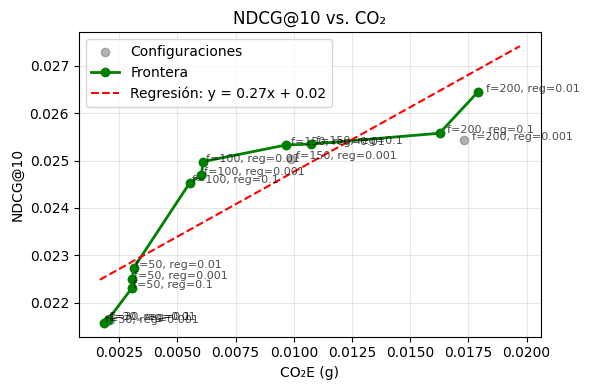

NDCG Frontier Linear Regression:
Slope (m): 0.2730
Intercept (b): 0.0220


In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(
    [r['co2e'] for r in als_results_dict],
    [r['mean_ndcg'] for r in als_results_dict],
    color='gray', alpha=0.6, label='Configuraciones'
)

co2e_ndcg = [r['co2e'] for r in ndcg_frontier]
mean_ndcg_ndcg = [r['mean_ndcg'] for r in ndcg_frontier]

plt.plot(
    co2e_ndcg,
    mean_ndcg_ndcg,
    color='green', marker='o', linewidth=2, label='Frontera'
)


m_ndcg, b_ndcg = np.polyfit(co2e_ndcg, mean_ndcg_ndcg, 1)
x_range_ndcg = np.array([min(co2e_ndcg) * 0.9, max(co2e_ndcg) * 1.1])
plt.plot(x_range_ndcg, m_ndcg * x_range_ndcg + b_ndcg, color='red', linestyle='--', label=f'Regresión: y = {m_ndcg:.2f}x + {b_ndcg:.2f}')


for r in als_results_dict:
    label = f"f={r['factors']}, reg={r['regularization']}"
    plt.text(r['co2e']*1.02, r['mean_ndcg'], label, fontsize=8, alpha=0.7)

plt.xlabel("CO₂E (g)")
plt.ylabel("NDCG@10")
plt.title("NDCG@10 vs. CO₂")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("NDCG Frontier Linear Regression:")
print(f"Slope (m): {m_ndcg:.4f}")
print(f"Intercept (b): {b_ndcg:.4f}")

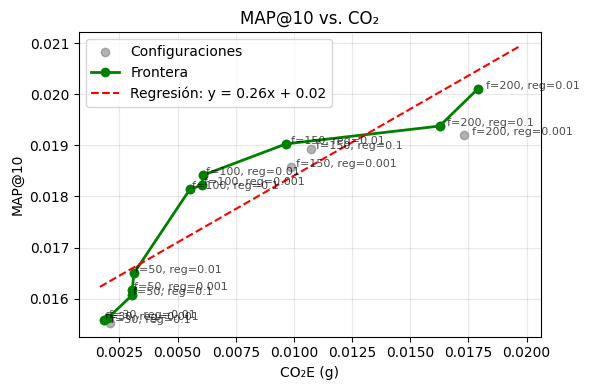

MAP Frontier Linear Regression:
Slope (m): 0.2614
Intercept (b): 0.0158


In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(
    [r['co2e'] for r in als_results_dict],
    [r['mean_ap'] for r in als_results_dict],
    color='gray', alpha=0.6, label='Configuraciones'
)

co2e_map = [r['co2e'] for r in map_frontier]
mean_ap_map = [r['mean_ap'] for r in map_frontier]


plt.plot(
    co2e_map,
    mean_ap_map,
    color='green', marker='o', linewidth=2, label='Frontera'
)

m_map, b_map = np.polyfit(co2e_map, mean_ap_map, 1)
x_range_map = np.array([min(co2e_map) * 0.9, max(co2e_map) * 1.1])
plt.plot(x_range_map, m_map * x_range_map + b_map, color='red', linestyle='--', label=f'Regresión: y = {m_map:.2f}x + {b_map:.2f}')


for r in als_results_dict:
    label = f"f={r['factors']}, reg={r['regularization']}"
    plt.text(r['co2e']*1.02, r['mean_ap'], label, fontsize=8, alpha=0.7)

plt.xlabel("CO₂E (g)")
plt.ylabel("MAP@10")
plt.title("MAP@10 vs. CO₂")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("MAP Frontier Linear Regression:")
print(f"Slope (m): {m_map:.4f}")
print(f"Intercept (b): {b_map:.4f}")

# DeepFM con Tensorflow-recommenders


In [ ]:
!    pip install tensorflow-recommenders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_recommenders as tfrs

Preprocesamiento de datos

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


unique_users = train_df["user_id"].unique()
unique_items = train_df["item_id"].unique()

user2idx = {u: i for i, u in enumerate(unique_users)}
item2idx = {i: j for j, i in enumerate(unique_items)}

idx2user = {i: u for u, i in user2idx.items()}
idx2item = {j: i for i, j in item2idx.items()}


rating_mean = train_df["rating"].mean()
rating_std = train_df["rating"].std()

train_df["rating_normalized"] = (train_df["rating"] - rating_mean) / rating_std

train_df["user_id_encoded"] = train_df["user_id"].map(user2idx)
train_df["item_id_encoded"] = train_df["item_id"].map(item2idx)

user_vocab_size = len(user2idx) + 1
item_vocab_size = len(item2idx) + 1

In [ ]:
all_genres = set()
for original_item_id in unique_items:
    genres = item_genre_dict.get(original_item_id, [])
    all_genres.update(genres)

genre2idx = {genre: idx for idx, genre in enumerate(all_genres, start=1)}
idx2genre = {idx: genre for genre, idx in genre2idx.items()}
genre_vocab_size = len(genre2idx) + 1


In [ ]:
print(genre_vocab_size)

78634


In [ ]:
def get_genre_features(encoded_item_id, max_genres=5):
    original_item_id = idx2item.get(encoded_item_id)

    if original_item_id is None:
        return [0] * max_genres, [0.0] * max_genres

    genres = item_genre_dict.get(original_item_id, [])
    genre_ids = [genre2idx[g] for g in genres[:max_genres]]
    genre_weights = [1.0] * len(genre_ids)

    while len(genre_ids) < max_genres:
        genre_ids.append(0)
        genre_weights.append(0.0)

    return genre_ids[:max_genres], genre_weights[:max_genres]

In [ ]:
train_genre_ids = []
train_genre_weights = []

for encoded_item_id in train_df["item_id_encoded"]:
    genre_ids, genre_weights = get_genre_features(encoded_item_id)
    train_genre_ids.append(genre_ids)
    train_genre_weights.append(genre_weights)

train_df["genre_ids"] = train_genre_ids
train_df["genre_weights"] = train_genre_weights

In [ ]:
from tensorflow.keras import layers

class DeepFMRankingModel(tfrs.models.Model):
    def __init__(self, user_vocab_size, item_vocab_size, genre_vocab_size=None, embed_dim=32,
                 deep_layers=[64, 32], learning_rate=0.001):
        super().__init__()

        self.user_embedding = layers.Embedding(
            input_dim=user_vocab_size,
            output_dim=embed_dim,
            embeddings_initializer='glorot_uniform',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.item_embedding = layers.Embedding(
            input_dim=item_vocab_size,
            output_dim=embed_dim,
            embeddings_initializer='glorot_uniform',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )

        if genre_vocab_size is not None:
            self.genre_embedding = layers.Embedding(
                input_dim=genre_vocab_size,
                output_dim=8,
                embeddings_initializer='glorot_uniform',
                embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
            )
            self.use_genres = True
        else:
            self.use_genres = False

        self.user_bias = layers.Embedding(input_dim=user_vocab_size, output_dim=1)
        self.item_bias = layers.Embedding(input_dim=item_vocab_size, output_dim=1)
        self.global_bias = tf.Variable(0.0)

        deep_net = []
        for units in deep_layers:
            deep_net.append(layers.Dense(units, activation='relu'))
            deep_net.append(layers.Dropout(0.5))
        deep_net.append(layers.Dense(1))

        self.deep_network = tf.keras.Sequential(deep_net)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=5000,
            decay_rate=0.96,
            staircase=True
        ))
        self.compile(optimizer=optimizer)

    def call(self, features):
        user_id = features["user_id"]
        item_id = features["item_id"]

        user_emb = self.user_embedding(user_id)
        item_emb = self.item_embedding(item_id)

        user_bias = tf.squeeze(self.user_bias(user_id), axis=-1)
        item_bias = tf.squeeze(self.item_bias(item_id), axis=-1)

        interaction = tf.reduce_sum(user_emb * item_emb, axis=1)

        fm_output = self.global_bias + user_bias + item_bias + interaction

        if self.use_genres and "genre_ids" in features and "genre_weights" in features:
            genre_ids = features["genre_ids"]
            genre_weights = features["genre_weights"]


            genre_emb = self.genre_embedding(genre_ids)
            genre_weights_expanded = tf.expand_dims(genre_weights, axis=-1)

            weighted_genre_emb = tf.reduce_sum(genre_emb * genre_weights_expanded, axis=1)

            deep_input = tf.concat([user_emb, item_emb, weighted_genre_emb], axis=1)
        else:
            deep_input = tf.concat([user_emb, item_emb], axis=1)

        deep_output = tf.squeeze(self.deep_network(deep_input), axis=-1)

        return fm_output + deep_output

    def compute_loss(self, features, training=False):
        labels = features["rating"]

        inputs = {
            "user_id": features["user_id"],
            "item_id": features["item_id"]
        }

        if "genre_ids" in features and "genre_weights" in features:
            inputs["genre_ids"] = features["genre_ids"]
            inputs["genre_weights"] = features["genre_weights"]

        predictions = self(inputs)
        return self.task(labels=labels, predictions=predictions)

In [ ]:

train_deepfm = tf.data.Dataset.from_tensor_slices({
    "user_id": train_df["user_id_encoded"].astype(np.int32).values,
    "item_id": train_df["item_id_encoded"].astype(np.int32).values,
    "genre_ids": np.array(train_df["genre_ids"].tolist(), dtype=np.int32),
    "genre_weights": np.array(train_df["genre_weights"].tolist(), dtype=np.float32),
    "rating": train_df["rating_normalized"].astype(np.float32).values,
}).batch(1024)

model = DeepFMRankingModel(
    user_vocab_size=user_vocab_size,
    item_vocab_size=item_vocab_size,
    genre_vocab_size=None,
    embed_dim=16,
    deep_layers=[64, 32],
    learning_rate=0.001
)

model.fit(train_deepfm, epochs=5)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


605/605 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7956 - regularization_loss: 5.1281e-04 - root_mean_squared_error: 0.9171 - total_loss: 0.7961
Epoch 2/5
605/605 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5668 - regularization_loss: 0.0024 - root_mean_squared_error: 0.7733 - total_loss: 0.5692
Epoch 3/5
605/605 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3898 - regularization_loss: 0.0042 - root_mean_squared_error: 0.6410 - total_loss: 0.3940
Epoch 4/5
605/605 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3381 - regularization_loss: 0.0052 - root_mean_squared_error: 0.5922 - total_loss: 0.3433
Epoch 5/5
605/605 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3137 - regularization_loss: 0.0062 - root_mean_squared_error: 0.5663 - total_loss: 0.3198


In [ ]:
def deepfm_recommend_top_k(model, train_df, user_id, K=10, max_genres=5, use_genres =False):
    user_encoded = user2idx[user_id]

    all_item_encoded = np.array(list(idx2item.keys()), dtype=np.int32)
    user_ids = np.full_like(all_item_encoded, fill_value=user_encoded, dtype=np.int32)

    inputs = {
        "user_id": tf.constant(user_ids, dtype=tf.int32),
        "item_id": tf.constant(all_item_encoded, dtype=tf.int32)
    }

    if use_genres:
        genre_ids_list = []
        genre_weights_list = []

        for encoded_item_id in all_item_encoded:
            genre_ids, genre_weights = get_genre_features(encoded_item_id, max_genres=max_genres)
            genre_ids_list.append(genre_ids)
            genre_weights_list.append(genre_weights)

        inputs["genre_ids"] = tf.constant(np.array(genre_ids_list, dtype=np.int32))
        inputs["genre_weights"] = tf.constant(np.array(genre_weights_list, dtype=np.float32))

    scores = model(inputs, training=False).numpy().flatten()

    top_indices = np.argsort(scores)[::-1][:K]
    top_item_encoded = all_item_encoded[top_indices]

    top_items_original = [idx2item[i] for i in top_item_encoded]

    return top_items_original


## Experimentos Deepfm

In [ ]:
import itertools

embedding_sizes = [16, 32]
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [512, 1024]

deepfm_configurations = []
for embedding_size, learning_rate, batch_size in itertools.product(embedding_sizes, learning_rates, batch_sizes):
    deepfm_configurations.append({'embedding_size': embedding_size, 'learning_rate': learning_rate, 'batch_size': batch_size})

print(deepfm_configurations)

In [ ]:
import time
deepfm_results = []
n = 10
for config in deepfm_configurations:
  embedding_size = config['embedding_size']
  learning_rate = config['learning_rate']
  batch_size = config['batch_size']

  train_deepfm = tf.data.Dataset.from_tensor_slices({
    "user_id": train_df["user_id_encoded"].astype(np.int32).values,
    "item_id": train_df["item_id_encoded"].astype(np.int32).values,
    "genre_ids": np.array(train_df["genre_ids"].tolist(), dtype=np.int32),
    "genre_weights": np.array(train_df["genre_weights"].tolist(), dtype=np.float32),
    "rating": train_df["rating_normalized"].astype(np.float32).values,
}).batch(batch_size)

  model = DeepFMRankingModel(
      user_vocab_size=user_vocab_size,
      item_vocab_size=item_vocab_size,
      genre_vocab_size=genre_vocab_size,
      embed_dim=embedding_size,
      deep_layers=[64, 32],
      learning_rate=learning_rate
  )

  start_time = time.time()
  model.fit(train_deepfm, epochs=5)
  end_time = time.time()
  deep_fm_time = end_time - start_time

  mean_ap, mean_ndcg, mean_diversity, mean_novelty = get_base_metrics(model, 10, "tensorflow", ctx)

  map_c, ndcg_c, co2e = get_co2e_metrics(
      mean_ap,
      mean_ndcg,
      deep_fm_time,
      energy_consumption_t4,
      mean_carbon_intensity,
      mean_ap_random,
      mean_ndcg_random)

  deepfm_results.append({
      'embedding_size': embedding_size,
      'learning_rate': learning_rate,
      'batch_size': batch_size,
      'map': mean_ap,
      'ndcg': mean_ndcg,
      'diversity': mean_diversity,
      'novelty': mean_novelty,
      'map_c': map_c,
      'ndcg_c': ndcg_c,
      'co2e': co2e,
      'time': deep_fm_time
  })


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.6998 - regularization_loss: 1.3682e-04 - root_mean_squared_error: 0.8681 - total_loss: 0.6999
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6445 - regularization_loss: 2.9647e-04 - root_mean_squared_error: 0.8048 - total_loss: 0.6448
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6234 - regularization_loss: 4.6459e-04 - root_mean_squared_error: 0.7918 - total_loss: 0.6239
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5996 - regularization_loss: 6.5430e-04 - root_mean_squared_error: 0.7769 - total_loss: 0.6003
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.5790 - regularization_loss: 8.4349e-04 - root_mean_squared_error: 0.7632 - total_loss: 0.5799
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7083 - regularization_loss: 1.0848e-04 - root_mean_squared_error: 0.8803 - total_loss: 0.7084
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6417 - regularization_loss: 2.1265e-04 - root_mean_squared_error: 0.8043 - total_loss: 0.6419
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6152 - regularization_loss: 3.1980e-04 - root_mean_squared_error: 0.7871 - total_loss: 0.6155
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5931 - regularization_loss: 4.3040e-04 - root_mean_squared_error: 0.7724 - total_loss: 0.5935
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5757 - regularization_loss: 5.3950e-04 - root_mean_squared_error: 0.7609 - total_loss: 0.5762
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7208 - regularization_loss: 8.8349e-05 - root_mean_squared_error: 0.8948 - total_loss: 0.7209
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6460 - regularization_loss: 1.4969e-04 - root_mean_squared_error: 0.8060 - total_loss: 0.6461
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6246 - regularization_loss: 2.0634e-04 - root_mean_squared_error: 0.7921 - total_loss: 0.6248
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6059 - regularization_loss: 2.6440e-04 - root_mean_squared_error: 0.7800 - total_loss: 0.6061
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5900 - regularization_loss: 3.2307e-04 - root_mean_squared_error: 0.7696 - total_loss: 0.5903
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.6984 - regularization_loss: 1.3609e-04 - root_mean_squared_error: 0.8693 - total_loss: 0.6985
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6379 - regularization_loss: 3.0359e-04 - root_mean_squared_error: 0.8015 - total_loss: 0.6382
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6127 - regularization_loss: 4.8103e-04 - root_mean_squared_error: 0.7852 - total_loss: 0.6132
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5919 - regularization_loss: 6.6252e-04 - root_mean_squared_error: 0.7715 - total_loss: 0.5926
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.5741 - regularization_loss: 8.4440e-04 - root_mean_squared_error: 0.7598 - total_loss: 0.5750
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7100 - regularization_loss: 1.0555e-04 - root_mean_squared_error: 0.8811 - total_loss: 0.7101
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6471 - regularization_loss: 1.9907e-04 - root_mean_squared_error: 0.8074 - total_loss: 0.6473
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6228 - regularization_loss: 2.9891e-04 - root_mean_squared_error: 0.7906 - total_loss: 0.6231
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6062 - regularization_loss: 4.0173e-04 - root_mean_squared_error: 0.7797 - total_loss: 0.6066
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5902 - regularization_loss: 5.0860e-04 - root_mean_squared_error: 0.7696 - total_loss: 0.5907
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7193 - regularization_loss: 8.9758e-05 - root_mean_squared_error: 0.8942 - total_loss: 0.7193
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6409 - regularization_loss: 1.5716e-04 - root_mean_squared_error: 0.8031 - total_loss: 0.6411
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6231 - regularization_loss: 2.1481e-04 - root_mean_squared_error: 0.7908 - total_loss: 0.6233
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6082 - regularization_loss: 2.6973e-04 - root_mean_squared_error: 0.7816 - total_loss: 0.6085
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5942 - regularization_loss: 3.2591e-04 - root_mean_squared_error: 0.7724 - total_loss: 0.5945
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_11', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7006 - regularization_loss: 1.3976e-04 - root_mean_squared_error: 0.8688 - total_loss: 0.7008
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6416 - regularization_loss: 3.0512e-04 - root_mean_squared_error: 0.8038 - total_loss: 0.6419
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6175 - regularization_loss: 4.7704e-04 - root_mean_squared_error: 0.7878 - total_loss: 0.6180
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5966 - regularization_loss: 6.6259e-04 - root_mean_squared_error: 0.7742 - total_loss: 0.5972
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5774 - regularization_loss: 8.5320e-04 - root_mean_squared_error: 0.7617 - total_loss: 0.5782
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7094 - regularization_loss: 1.1187e-04 - root_mean_squared_error: 0.8824 - total_loss: 0.7095
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6418 - regularization_loss: 2.1313e-04 - root_mean_squared_error: 0.8038 - total_loss: 0.6420
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6182 - regularization_loss: 3.1565e-04 - root_mean_squared_error: 0.7883 - total_loss: 0.6185
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5988 - regularization_loss: 4.2441e-04 - root_mean_squared_error: 0.7753 - total_loss: 0.5992
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5818 - regularization_loss: 5.3387e-04 - root_mean_squared_error: 0.7642 - total_loss: 0.5823
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.7187 - regularization_loss: 8.8770e-05 - root_mean_squared_error: 0.8919 - total_loss: 0.7188
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6470 - regularization_loss: 1.4741e-04 - root_mean_squared_error: 0.8063 - total_loss: 0.6471
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6297 - regularization_loss: 1.9744e-04 - root_mean_squared_error: 0.7948 - total_loss: 0.6299
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6147 - regularization_loss: 2.4943e-04 - root_mean_squared_error: 0.7853 - total_loss: 0.6150
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6011 - regularization_loss: 3.0542e-04 - root_mean_squared_error: 0.7765 - total_loss: 0.6014
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.6932 - regularization_loss: 2.4107e-04 - root_mean_squared_error: 0.8641 - total_loss: 0.6934
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6293 - regularization_loss: 5.5859e-04 - root_mean_squared_error: 0.7969 - total_loss: 0.6299
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5975 - regularization_loss: 9.0753e-04 - root_mean_squared_error: 0.7768 - total_loss: 0.5984
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5688 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7575 - total_loss: 0.5701
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.5441 - regularization_loss: 0.0016 - root_mean_squared_error: 0.7406 - total_loss: 0.5458
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6999 - regularization_loss: 1.7958e-04 - root_mean_squared_error: 0.8732 - total_loss: 0.7001
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6290 - regularization_loss: 3.6166e-04 - root_mean_squared_error: 0.7967 - total_loss: 0.6294
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5983 - regularization_loss: 5.5559e-04 - root_mean_squared_error: 0.7765 - total_loss: 0.5989
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5731 - regularization_loss: 7.6505e-04 - root_mean_squared_error: 0.7598 - total_loss: 0.5738
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5510 - regularization_loss: 9.7857e-04 - root_mean_squared_error: 0.7451 - total_loss: 0.5520
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7135 - regularization_loss: 1.4368e-04 - root_mean_squared_error: 0.8873 - total_loss: 0.7137
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6386 - regularization_loss: 2.4927e-04 - root_mean_squared_error: 0.8026 - total_loss: 0.6389
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6123 - regularization_loss: 3.5595e-04 - root_mean_squared_error: 0.7850 - total_loss: 0.6127
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5905 - regularization_loss: 4.6922e-04 - root_mean_squared_error: 0.7708 - total_loss: 0.5910
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5718 - regularization_loss: 5.8681e-04 - root_mean_squared_error: 0.7587 - total_loss: 0.5723
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_17', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6923 - regularization_loss: 2.3546e-04 - root_mean_squared_error: 0.8633 - total_loss: 0.6925
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6251 - regularization_loss: 5.6460e-04 - root_mean_squared_error: 0.7953 - total_loss: 0.6257
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5902 - regularization_loss: 9.2455e-04 - root_mean_squared_error: 0.7720 - total_loss: 0.5911
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5639 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7536 - total_loss: 0.5652
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5414 - regularization_loss: 0.0017 - root_mean_squared_error: 0.7384 - total_loss: 0.5431
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7001 - regularization_loss: 1.8143e-04 - root_mean_squared_error: 0.8737 - total_loss: 0.7003
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6336 - regularization_loss: 3.5973e-04 - root_mean_squared_error: 0.7987 - total_loss: 0.6339
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6057 - regularization_loss: 5.4945e-04 - root_mean_squared_error: 0.7814 - total_loss: 0.6062
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5784 - regularization_loss: 7.6519e-04 - root_mean_squared_error: 0.7635 - total_loss: 0.5792
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5551 - regularization_loss: 9.8168e-04 - root_mean_squared_error: 0.7476 - total_loss: 0.5561
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_19', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.7151 - regularization_loss: 1.4282e-04 - root_mean_squared_error: 0.8880 - total_loss: 0.7153
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6448 - regularization_loss: 2.4446e-04 - root_mean_squared_error: 0.8061 - total_loss: 0.6450
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6186 - regularization_loss: 3.5190e-04 - root_mean_squared_error: 0.7889 - total_loss: 0.6189
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5945 - regularization_loss: 4.6876e-04 - root_mean_squared_error: 0.7736 - total_loss: 0.5950
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5725 - regularization_loss: 5.9105e-04 - root_mean_squared_error: 0.7596 - total_loss: 0.5731
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.6930 - regularization_loss: 2.4467e-04 - root_mean_squared_error: 0.8647 - total_loss: 0.6932
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6224 - regularization_loss: 5.8771e-04 - root_mean_squared_error: 0.7939 - total_loss: 0.6229
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.5870 - regularization_loss: 9.4449e-04 - root_mean_squared_error: 0.7699 - total_loss: 0.5880
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5622 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7523 - total_loss: 0.5635
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5414 - regularization_loss: 0.0017 - root_mean_squared_error: 0.7381 - total_loss: 0.5430
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7012 - regularization_loss: 1.8565e-04 - root_mean_squared_error: 0.8754 - total_loss: 0.7014
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6311 - regularization_loss: 3.7470e-04 - root_mean_squared_error: 0.7981 - total_loss: 0.6315
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6008 - regularization_loss: 5.7746e-04 - root_mean_squared_error: 0.7785 - total_loss: 0.6013
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5744 - regularization_loss: 7.9379e-04 - root_mean_squared_error: 0.7614 - total_loss: 0.5752
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5512 - regularization_loss: 0.0010 - root_mean_squared_error: 0.7460 - total_loss: 0.5522
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_22', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.7165 - regularization_loss: 1.5084e-04 - root_mean_squared_error: 0.8921 - total_loss: 0.7166
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6398 - regularization_loss: 2.6258e-04 - root_mean_squared_error: 0.8033 - total_loss: 0.6401
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6120 - regularization_loss: 3.7492e-04 - root_mean_squared_error: 0.7849 - total_loss: 0.6124
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5876 - regularization_loss: 4.9501e-04 - root_mean_squared_error: 0.7691 - total_loss: 0.5881
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5676 - regularization_loss: 6.1616e-04 - root_mean_squared_error: 0.7559 - total_loss: 0.5682
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_23', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6886 - regularization_loss: 4.3107e-04 - root_mean_squared_error: 0.8610 - total_loss: 0.6891
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6130 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7886 - total_loss: 0.6141
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5715 - regularization_loss: 0.0018 - root_mean_squared_error: 0.7608 - total_loss: 0.5733
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5377 - regularization_loss: 0.0025 - root_mean_squared_error: 0.7373 - total_loss: 0.5402
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5073 - regularization_loss: 0.0032 - root_mean_squared_error: 0.7160 - total_loss: 0.5105
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_24', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6941 - regularization_loss: 3.3540e-04 - root_mean_squared_error: 0.8707 - total_loss: 0.6944
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6168 - regularization_loss: 7.1093e-04 - root_mean_squared_error: 0.7895 - total_loss: 0.6175
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5798 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7650 - total_loss: 0.5810
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5487 - regularization_loss: 0.0016 - root_mean_squared_error: 0.7442 - total_loss: 0.5503
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5211 - regularization_loss: 0.0020 - root_mean_squared_error: 0.7255 - total_loss: 0.5231
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_25', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7063 - regularization_loss: 2.5350e-04 - root_mean_squared_error: 0.8818 - total_loss: 0.7065
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6278 - regularization_loss: 4.5781e-04 - root_mean_squared_error: 0.7965 - total_loss: 0.6283
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5958 - regularization_loss: 6.7281e-04 - root_mean_squared_error: 0.7755 - total_loss: 0.5965
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5672 - regularization_loss: 9.0412e-04 - root_mean_squared_error: 0.7570 - total_loss: 0.5681
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.5414 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7397 - total_loss: 0.5425
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_26', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6883 - regularization_loss: 4.3732e-04 - root_mean_squared_error: 0.8608 - total_loss: 0.6887
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6167 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7902 - total_loss: 0.6178
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.5729 - regularization_loss: 0.0018 - root_mean_squared_error: 0.7617 - total_loss: 0.5747
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5369 - regularization_loss: 0.0025 - root_mean_squared_error: 0.7363 - total_loss: 0.5394
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5055 - regularization_loss: 0.0032 - root_mean_squared_error: 0.7143 - total_loss: 0.5087
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_27', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6951 - regularization_loss: 3.1400e-04 - root_mean_squared_error: 0.8699 - total_loss: 0.6954
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6226 - regularization_loss: 6.6233e-04 - root_mean_squared_error: 0.7936 - total_loss: 0.6232
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5848 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7691 - total_loss: 0.5859
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5518 - regularization_loss: 0.0015 - root_mean_squared_error: 0.7470 - total_loss: 0.5533
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5225 - regularization_loss: 0.0019 - root_mean_squared_error: 0.7267 - total_loss: 0.5244
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_28', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.7061 - regularization_loss: 2.5599e-04 - root_mean_squared_error: 0.8828 - total_loss: 0.7064
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6250 - regularization_loss: 4.6190e-04 - root_mean_squared_error: 0.7952 - total_loss: 0.6255
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5904 - regularization_loss: 6.8070e-04 - root_mean_squared_error: 0.7724 - total_loss: 0.5911
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5623 - regularization_loss: 9.1038e-04 - root_mean_squared_error: 0.7539 - total_loss: 0.5632
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5379 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7376 - total_loss: 0.5391
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_29', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6887 - regularization_loss: 4.4252e-04 - root_mean_squared_error: 0.8620 - total_loss: 0.6892
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6135 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7886 - total_loss: 0.6146
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5725 - regularization_loss: 0.0018 - root_mean_squared_error: 0.7611 - total_loss: 0.5743
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5396 - regularization_loss: 0.0025 - root_mean_squared_error: 0.7381 - total_loss: 0.5421
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5099 - regularization_loss: 0.0032 - root_mean_squared_error: 0.7181 - total_loss: 0.5132
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_30', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6961 - regularization_loss: 3.1928e-04 - root_mean_squared_error: 0.8701 - total_loss: 0.6964
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6185 - regularization_loss: 6.8183e-04 - root_mean_squared_error: 0.7915 - total_loss: 0.6191
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5797 - regularization_loss: 0.0011 - root_mean_squared_error: 0.7654 - total_loss: 0.5808
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5481 - regularization_loss: 0.0015 - root_mean_squared_error: 0.7443 - total_loss: 0.5497
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5203 - regularization_loss: 0.0019 - root_mean_squared_error: 0.7257 - total_loss: 0.5222
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_31', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7037 - regularization_loss: 2.5507e-04 - root_mean_squared_error: 0.8799 - total_loss: 0.7039
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6262 - regularization_loss: 4.6419e-04 - root_mean_squared_error: 0.7956 - total_loss: 0.6267
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5903 - regularization_loss: 6.9109e-04 - root_mean_squared_error: 0.7729 - total_loss: 0.5910
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5604 - regularization_loss: 9.2788e-04 - root_mean_squared_error: 0.7527 - total_loss: 0.5613
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5365 - regularization_loss: 0.0012 - root_mean_squared_error: 0.7355 - total_loss: 0.5376
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_32', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6849 - regularization_loss: 7.8649e-04 - root_mean_squared_error: 0.8576 - total_loss: 0.6857
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6046 - regularization_loss: 0.0020 - root_mean_squared_error: 0.7845 - total_loss: 0.6066
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5489 - regularization_loss: 0.0035 - root_mean_squared_error: 0.7481 - total_loss: 0.5524
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5019 - regularization_loss: 0.0050 - root_mean_squared_error: 0.7146 - total_loss: 0.5069
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4599 - regularization_loss: 0.0065 - root_mean_squared_error: 0.6844 - total_loss: 0.4664
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6890 - regularization_loss: 5.7079e-04 - root_mean_squared_error: 0.8633 - total_loss: 0.6896
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6112 - regularization_loss: 0.0012 - root_mean_squared_error: 0.7874 - total_loss: 0.6124
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5657 - regularization_loss: 0.0020 - root_mean_squared_error: 0.7575 - total_loss: 0.5677
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5261 - regularization_loss: 0.0029 - root_mean_squared_error: 0.7304 - total_loss: 0.5289
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4905 - regularization_loss: 0.0037 - root_mean_squared_error: 0.7054 - total_loss: 0.4943
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_34', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.6984 - regularization_loss: 4.5055e-04 - root_mean_squared_error: 0.8741 - total_loss: 0.6988
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6178 - regularization_loss: 8.2838e-04 - root_mean_squared_error: 0.7914 - total_loss: 0.6187
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5752 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7641 - total_loss: 0.5765
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.5387 - regularization_loss: 0.0017 - root_mean_squared_error: 0.7393 - total_loss: 0.5404
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5079 - regularization_loss: 0.0022 - root_mean_squared_error: 0.7173 - total_loss: 0.5101
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_35', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6843 - regularization_loss: 7.8974e-04 - root_mean_squared_error: 0.8574 - total_loss: 0.6851
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6022 - regularization_loss: 0.0020 - root_mean_squared_error: 0.7829 - total_loss: 0.6042
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.5476 - regularization_loss: 0.0034 - root_mean_squared_error: 0.7471 - total_loss: 0.5511
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4997 - regularization_loss: 0.0050 - root_mean_squared_error: 0.7133 - total_loss: 0.5047
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4572 - regularization_loss: 0.0065 - root_mean_squared_error: 0.6826 - total_loss: 0.4637
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_36', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6892 - regularization_loss: 5.7612e-04 - root_mean_squared_error: 0.8638 - total_loss: 0.6898
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6111 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7872 - total_loss: 0.6124
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5661 - regularization_loss: 0.0021 - root_mean_squared_error: 0.7577 - total_loss: 0.5682
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5253 - regularization_loss: 0.0029 - root_mean_squared_error: 0.7300 - total_loss: 0.5282
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4881 - regularization_loss: 0.0038 - root_mean_squared_error: 0.7043 - total_loss: 0.4919
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_37', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.6966 - regularization_loss: 4.5128e-04 - root_mean_squared_error: 0.8730 - total_loss: 0.6971
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6147 - regularization_loss: 8.2905e-04 - root_mean_squared_error: 0.7892 - total_loss: 0.6155
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5703 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7608 - total_loss: 0.5716
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5332 - regularization_loss: 0.0017 - root_mean_squared_error: 0.7353 - total_loss: 0.5349
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5026 - regularization_loss: 0.0022 - root_mean_squared_error: 0.7134 - total_loss: 0.5048
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_38', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6859 - regularization_loss: 8.0609e-04 - root_mean_squared_error: 0.8593 - total_loss: 0.6867
Epoch 2/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6038 - regularization_loss: 0.0020 - root_mean_squared_error: 0.7835 - total_loss: 0.6059
Epoch 3/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5509 - regularization_loss: 0.0035 - root_mean_squared_error: 0.7488 - total_loss: 0.5544
Epoch 4/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5051 - regularization_loss: 0.0050 - root_mean_squared_error: 0.7165 - total_loss: 0.5102
Epoch 5/5
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4629 - regularization_loss: 0.0066 - root_mean_squared_error: 0.6864 - total_loss: 0.4694
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_39', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6901 - regularization_loss: 5.7732e-04 - root_mean_squared_error: 0.8643 - total_loss: 0.6907
Epoch 2/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6123 - regularization_loss: 0.0012 - root_mean_squared_error: 0.7883 - total_loss: 0.6135
Epoch 3/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5637 - regularization_loss: 0.0021 - root_mean_squared_error: 0.7567 - total_loss: 0.5658
Epoch 4/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5227 - regularization_loss: 0.0029 - root_mean_squared_error: 0.7284 - total_loss: 0.5256
Epoch 5/5
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4862 - regularization_loss: 0.0038 - root_mean_squared_error: 0.7030 - total_loss: 0.4899
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'deep_fm_ranking_model_40', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


587/587 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.6986 - regularization_loss: 4.5638e-04 - root_mean_squared_error: 0.8752 - total_loss: 0.6991
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6155 - regularization_loss: 8.4016e-04 - root_mean_squared_error: 0.7903 - total_loss: 0.6164
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5726 - regularization_loss: 0.0013 - root_mean_squared_error: 0.7623 - total_loss: 0.5739
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5380 - regularization_loss: 0.0017 - root_mean_squared_error: 0.7388 - total_loss: 0.5398
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5088 - regularization_loss: 0.0022 - root_mean_squared_error: 0.7179 - total_loss: 0.5110


In [ ]:
df_deepfm_results = pd.DataFrame(deepfm_results)

df_deepfm_results.to_csv('deepfm_results.csv', index=False)

## Resultados DeepFM

In [ ]:
df_deepfm_results = pd.read_csv('deepfm_results.csv')
df_deepfm_results.rename(columns={'map': 'mean_ap', 'ndcg': 'mean_ndcg'}, inplace=True)
deepfm_results_dict = df_deepfm_results.to_dict(orient='records')

In [ ]:
print(deepfm_results_dict)

[{'embedding_size': 8, 'learning_rate': 0.001, 'batch_size': 256, 'mean_ap': 0.1100431822005607, 'mean_ndcg': 0.1701527183487802, 'diversity': 8.46538588936734, 'novelty': 10.49558031626589, 'map_c': 27.03751584820108, 'ndcg_c': 41.81612385581801, 'co2e': 0.2712709251058599, 'time': 45.647692918777466}, {'embedding_size': 8, 'learning_rate': 0.001, 'batch_size': 512, 'mean_ap': 0.1084616378018582, 'mean_ndcg': 0.1698777191493851, 'diversity': 8.792480953958265, 'novelty': 10.489358680171634, 'map_c': 42.10349797269068, 'ndcg_c': 66.39084739381909, 'co2e': 0.170445161147664, 'time': 28.681394338607788}, {'embedding_size': 8, 'learning_rate': 0.001, 'batch_size': 1024, 'mean_ap': 0.1346930529047955, 'mean_ndcg': 0.196169609013016, 'diversity': 7.987744286187479, 'novelty': 10.257711786205572, 'map_c': 77.89287452423615, 'ndcg_c': 110.84576563084734, 'co2e': 0.125807130202651, 'time': 21.16999912261963}, {'embedding_size': 8, 'learning_rate': 0.0001, 'batch_size': 256, 'mean_ap': 0.123812

In [ ]:
best_results = filter_for_efficiency_in_each_metric(deepfm_results_dict)
map_frontier = pareto_filter(deepfm_results_dict, 'mean_ap')
ndcg_frontier = pareto_filter(deepfm_results_dict, 'mean_ndcg')

In [ ]:
map_frontier.sort(key=lambda x: x['map_c'])
ndcg_frontier.sort(key=lambda x: x['ndcg_c'])
print([(result["mean_ap"], result['embedding_size'], result['batch_size'], result["learning_rate"]) for result in map_frontier])
print([(result["mean_ndcg"], result['embedding_size'], result['batch_size'], result["learning_rate"]) for result in ndcg_frontier])

[(0.1362211121889412, 16, 512, 0.001), (0.1346930529047955, 8, 1024, 0.001), (0.1325268312810755, 8, 1024, 0.0001)]
[(0.1966611716613616, 16, 512, 0.001), (0.196169609013016, 8, 1024, 0.001), (0.1960916519122392, 8, 1024, 0.0001)]


In [ ]:
best_ndcg_c = best_results["best_ndcg_c"]
best_map_c = best_results["best_map_c"]
print("Best NDCG-C model:", f"ndcg_c={best_ndcg_c['ndcg_c']} ,embedding_size={best_ndcg_c['embedding_size']}, batch_size={best_ndcg_c['batch_size']}, learning_rate={best_ndcg_c['learning_rate']}")
print("Best MAP-C model", f"map_c={best_ndcg_c['map_c']} ,embedding_size={best_map_c['embedding_size']}, batch_size={best_map_c['batch_size']}, learning_rate={best_map_c['learning_rate']}")


Best NDCG-C model: ndcg_c=124.69712479499056 ,embedding_size=8, batch_size=1024, learning_rate=0.0001
Best MAP-C model map_c=85.73732441290022 ,embedding_size=8, batch_size=1024, learning_rate=0.0001


## Gráficos frontera métrica base y co2e

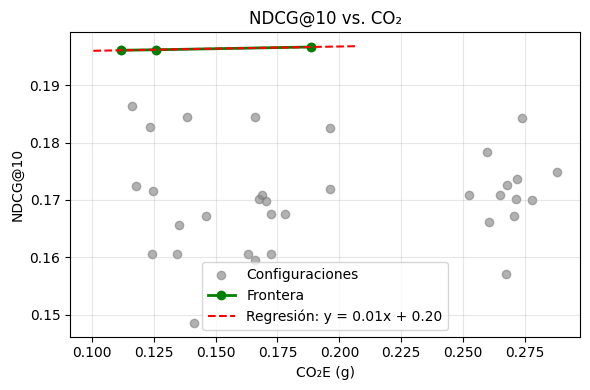

NDCG Frontier Linear Regression:
Slope (m): 0.0075
Intercept (b): 0.1952


In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(
    [r['co2e'] for r in deepfm_results_dict],
    [r['mean_ndcg'] for r in deepfm_results_dict],
    color='gray', alpha=0.6, label='Configuraciones'
)

co2e_ndcg = [r['co2e'] for r in ndcg_frontier]
mean_ndcg_ndcg = [r['mean_ndcg'] for r in ndcg_frontier]

plt.plot(
    co2e_ndcg,
    mean_ndcg_ndcg,
    color='green', marker='o', linewidth=2, label='Frontera'
)


m_ndcg, b_ndcg = np.polyfit(co2e_ndcg, mean_ndcg_ndcg, 1)
x_range_ndcg = np.array([min(co2e_ndcg) * 0.9, max(co2e_ndcg) * 1.1])
plt.plot(x_range_ndcg, m_ndcg * x_range_ndcg + b_ndcg, color='red', linestyle='--', label=f'Regresión: y = {m_ndcg:.2f}x + {b_ndcg:.2f}')


plt.xlabel("CO₂E (g)")
plt.ylabel("NDCG@10")
plt.title("NDCG@10 vs. CO₂")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("NDCG Frontier Linear Regression:")
print(f"Slope (m): {m_ndcg:.4f}")
print(f"Intercept (b): {b_ndcg:.4f}")

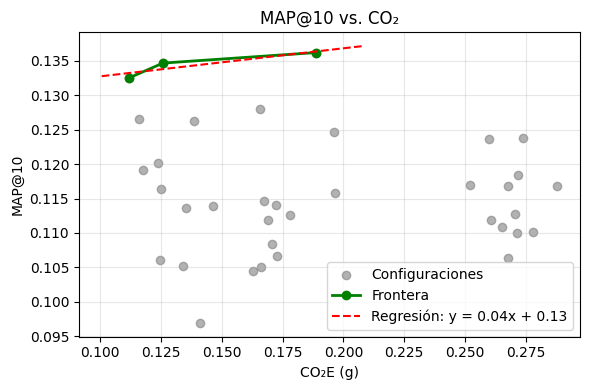

MAP Frontier Linear Regression:
Slope (m): 0.0408
Intercept (b): 0.1287


In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(
    [r['co2e'] for r in deepfm_results_dict],
    [r['mean_ap'] for r in deepfm_results_dict],
    color='gray', alpha=0.6, label='Configuraciones'
)

co2e_map = [r['co2e'] for r in map_frontier]
mean_ap_map = [r['mean_ap'] for r in map_frontier]


plt.plot(
    co2e_map,
    mean_ap_map,
    color='green', marker='o', linewidth=2, label='Frontera'
)

m_map, b_map = np.polyfit(co2e_map, mean_ap_map, 1)
x_range_map = np.array([min(co2e_map) * 0.9, max(co2e_map) * 1.1])
plt.plot(x_range_map, m_map * x_range_map + b_map, color='red', linestyle='--', label=f'Regresión: y = {m_map:.2f}x + {b_map:.2f}')


plt.xlabel("CO₂E (g)")
plt.ylabel("MAP@10")
plt.title("MAP@10 vs. CO₂")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("MAP Frontier Linear Regression:")
print(f"Slope (m): {m_map:.4f}")
print(f"Intercept (b): {b_map:.4f}")